In [1]:
# declare a list tasks whose products you want to use as inputs
upstream = None

from dotenv import load_dotenv
import sys, os

load_dotenv()  # load environment variables from .env file
PROJECT_DIR = os.getenv('PROJECT_DIR')
parent_dir = os.path.abspath(os.path.join(PROJECT_DIR, os.pardir))
sys.path.append(parent_dir)

In [2]:
# Parameters
product = {
    "nb": "/Users/macpro/Documents/GitHub/fuel-electric-hybrid-vehicle-ml/notebooks/train_model.ipynb",
    "model": "/Users/macpro/Documents/GitHub/fuel-electric-hybrid-vehicle-ml/models/hard_voting_classifier_co2_fuel.pkl",
}


In [3]:

from dotenv import load_dotenv
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, \
                            classification_report, \
                            accuracy_score,\
                            balanced_accuracy_score,\
                            ConfusionMatrixDisplay
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import joblib
from utils import read_data, remove_missing_values, var_list, numeric_features,\
                    preprocessor, categorical_features, categorical_transformer, numeric_transformer


TO DO: follow this tutorial to complete both smog and co2 ratings https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

In [4]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_pipeline, model_name):
    """
    This function trains and evaluates model, and generates confusion matrix, classification report, and accuracy score
    Parameters:
    ----------
        X_train
        y_train
        X_test
        y_test
        model_pipeline
        model_name
    Returns:
    -------
        None
    """
    
    model_pipeline.fit(X_train, y_train.values.ravel())


    # Predict
    y_pred = model_pipeline.predict(X_test)
    
    # Obtain accuracy score
    acc = accuracy_score(y_test, y_pred)
    print('accuracy is',accuracy_score(y_pred,y_test))
    
    score_train = model_pipeline.score(X_train, y_train)
    score_test = model_pipeline.score(X_test, y_test)
    print('score for training set', score_train, 'score for testing set', score_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy score", balanced_accuracy)
    
    report = classification_report(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    _ = ax.set_title(
        f"Confusion Matrix for {model_name}"
    )
    
    return fig

In [5]:
def classify_grid_search_cv_tuning(model, parameters, X_train, X_test, y_train, y_test, n_folds = 5, scoring='accuracy'):
    """
    This function tunes GridSearchCV model
    
    Parameters:
    ----------
        model
        parameters
        X_train
        X_test
        y_train
        y_test
        n_folds
        scoring
        
    Returns:
    --------
        best_model
        best_score
    """
    # Set up and fit model
    tune_model = GridSearchCV(model, param_grid=parameters, cv=n_folds, scoring=scoring)
    tune_model.fit(X_train, y_train.values.ravel())
    
    best_model = tune_model.best_estimator_
    best_score = tune_model.best_score_
    y_pred = best_model.predict(X_test)
    
    # Printing results
    print("Best parameters:", tune_model.best_params_)
    print("Cross-validated accuracy score on training data: {:0.4f}".format(tune_model.best_score_))
    print()

    print(classification_report(y_test, y_pred))
    
    return best_model, best_score

accuracy is 0.9495955196017424


score for training set 0.9947121034077556 score for testing set 0.9495955196017424
Balanced accuracy score 0.9261658848413624


Best parameters: {}
Cross-validated accuracy score on training data: 0.9833

              precision    recall  f1-score   support

           1       1.00      0.92      0.96        25
           2       0.93      0.99      0.96        82
           3       0.96      0.95      0.96       263
           4       0.96      0.95      0.95       375
           5       0.96      0.96      0.96       455
           6       0.93      0.94      0.93       198
           7       0.94      0.94      0.94       139
           8       0.90      0.78      0.84        36
           9       0.86      0.90      0.88        21
          10       1.00      0.92      0.96        13

    accuracy                           0.95      1607
   macro avg       0.94      0.93      0.93      1607
weighted avg       0.95      0.95      0.95      1607



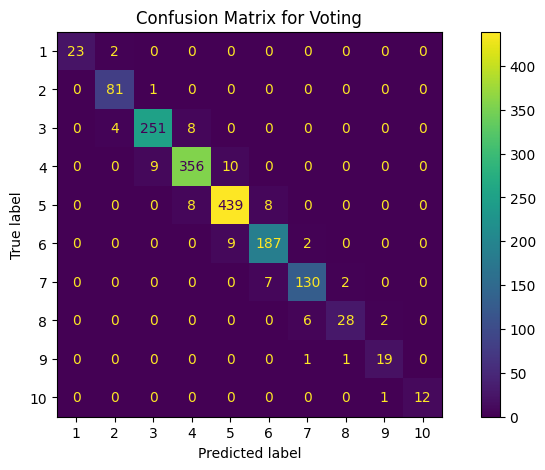

In [6]:
if __name__=="__main__":

    # Variable initialization
    raw_data_path = os.path.join(PROJECT_DIR, 'data', 'raw')
    clean_data_path = os.path.join(PROJECT_DIR, 'data', 'processed')
    predicted_data_path = os.path.join(PROJECT_DIR, 'data', 'predicted-data')
    model_path = os.path.join(PROJECT_DIR, 'models', 'hard_voting_classifier_co2_fuel.pkl')


    # Read data
    fuel_df, electric_df, hybrid_df = read_data(clean_data_path)
    non_na_rating_class, na_rating_class = remove_missing_values(fuel_df, drop_smog=False)
    
    # Set X and Y variables 
    # Response variable
    Y = non_na_rating_class[['co2_rating']]

    # Dependent variables
    X = non_na_rating_class[var_list]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    
    # Set up pipeline
    # Set up parameters for the model - numerical and categorical
    numeric_features =  numeric_features
    categorical_features = categorical_features

    # Use smote to balance the data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train[numeric_features], y_train)

    # Set up preprocessor
    preprocessor = preprocessor

    # Set up model pipeline
    clf1 = KNeighborsClassifier(3,)
    clf2 = SVC(gamma=2, C=1, random_state=42)
    clf3 = RandomForestClassifier(max_depth=100, n_estimators=10, max_features=1, random_state=42)

    classifiers = {"KNN": clf1, 
                   "SVM": clf2,
                   "RFC": clf3
                }

    eclf1 = VotingClassifier(estimators=[('knn', clf1), ('svm', clf2), ('dt', clf3)], voting='hard')
    model = Pipeline(
            steps=[("preprocessor", preprocessor), 
                    ("hard Voting", eclf1 )] #colsample  by tree, n estimators, max depth
                                                                        )
    fig = train_and_evaluate_model(X_train, y_train, X_test, y_test, model,"Voting")
    fig.savefig(os.path.join(PROJECT_DIR, 'reports', 'figures', 'hard_voting_classifier_co2_fuel.png'))


    params = {}
    best_dtc, dtc_score = classify_grid_search_cv_tuning(model, params, X_train, X_test, y_train, y_test, n_folds=10, scoring='balanced_accuracy')

    # Save model
    joblib.dump(best_dtc, model_path)